# Signal/Background Classification using Boosted Decision Trees

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

seed = 3456
np.random.seed(seed)

In [2]:
import os
print(os.getcwd())

/teamspace/studios/this_studio/all/BDT/DifferentAxionMass


## 1. Data Loading

In [3]:
ax15_signal = pd.read_csv('/teamspace/studios/this_studio/all/GNN/DifferentAxionMass/txtData/EtaBounded_txtData/processed_ppzaxbba_ax15_200k_minpt20_13jets.txt', 
                     sep = '\t')
ax75_signal = pd.read_csv('/teamspace/studios/this_studio/all/GNN/DifferentAxionMass/txtData/EtaBounded_txtData/processed_ppzaxbba_ax75_200k_minpt20_13jets.txt', 
                     sep = '\t')
background = pd.read_csv('/teamspace/studios/this_studio/all/GNN/data/bg_500k_minpt20_13jets_processed.txt', 
                         sep = '\t')

In [11]:
ax15_signal = ax15_signal.drop(['Unnamed: 0'], axis = 1)
ax75_signal = ax75_signal.drop(['Unnamed: 0'], axis = 1)
background = background.drop(['Unnamed: 0'], axis = 1)

In [12]:
ax15_signal['event_label'] = 1
ax75_signal['event_label'] = 1
background['event_label'] = 0

In [28]:
ax15_signal.head()

,eventno,jetmultiplicity,jet1_Eta,jet1_Phi,jet1_pT,jet1_Px,jet1_Py,jet1_Pz,jet1_E,jet1_btag,...,isophoton2_Pz,isophoton2_E,isophoton3_Eta,isophoton3_Phi,isophoton3_pT,isophoton3_Px,isophoton3_Py,isophoton3_Pz,isophoton3_E,event_label
0,0,1,-1.07125,-0.354984,27.8682,26.13070,-9.68631,-35.9007,45.4477,1,...,13.0745,21.8379,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,1,3,1.68988,-2.872670,65.3374,-62.98900,-17.35990,170.9970,183.0540,1,...,0.0000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,2,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,...,0.0000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,3,1,2.21481,-1.906970,23.6507,-7.80176,-22.32690,107.0260,109.6080,0,...,0.0000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,7,1,-1.32159,2.601460,35.3659,-30.33120,18.18700,-61.5840,71.0165,0,...,0.0000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [13]:
ax15_data = pd.concat([ax15_signal, background], axis = 0)
ax75_data = pd.concat([ax75_signal, background], axis = 0)

In [14]:
## Shuffling the data
ax15_data = ax15_data.sample(frac=1, random_state=seed)
ax75_data = ax75_data.sample(frac=1, random_state=seed)

# Filtering out the Complete NaN Rows

In [23]:
def get_nan_jets_idx(dataset:pd.DataFrame, num_jets:int = None) -> pd.DataFrame:
    dataset_copy = dataset.copy()
    for i in range(1,num_jets+1):
        jet_btag_col_names = ['jet' + str(i) + '_btag']
        dataset_copy = dataset_copy.drop(jet_btag_col_names, axis = 1)
    dataset_copy = dataset_copy.drop(['eventno', 'jetmultiplicity', 'event_label'], axis = 1)
    
    
    all_zero_or_nan_mask = ((dataset_copy == 0) | dataset_copy.isna()).all(axis=1)
    zero_or_nan_rows = dataset_copy[all_zero_or_nan_mask]
    return zero_or_nan_rows

In [24]:
ax15_data_zero_or_nan_rows = get_nan_jets_idx(ax15_data, num_jets = 13)
ax75_data_zero_or_nan_rows = get_nan_jets_idx(ax75_data, num_jets = 13)

# To remove those events in which all jets and 
ax15_data = ax15_data.drop(ax15_data_zero_or_nan_rows.index)
ax75_data = ax75_data.drop(ax75_data_zero_or_nan_rows.index)

# To remove those events with 0 jet multiplicity
ax15_data = ax15_data.drop(ax15_data[ax15_data['jetmultiplicity'] == 0].index)
ax75_data = ax75_data.drop(ax75_data[ax75_data['jetmultiplicity'] == 0].index)

# Counting Number of Btag Jets and Isophoton in each event

In [67]:
def count_jets_isophoton(dataset:pd.DataFrame, num_jets:int = None, num_isophotons:int = None) -> pd.DataFrame:
    dataset_copy = dataset.copy()
    with tqdm(total = len(dataset), desc = 'Processing') as pbar:
        jet_btag_col_names = ['jet' + str(i) + '_btag' for i in range (1, num_jets+1)]
        isophoton_pT_col_name = ['isophoton' + str(i) + '_pT' for i in range(1, num_isophotons+1)]
        num_btag_jets_lst = []
        num_isophoton_lst = []
        for i, event in dataset_copy.iterrows():
            count_btag_jets = list(event[jet_btag_col_names].to_numpy()).count(1.0)
            num_btag_jets_lst.append(count_btag_jets)

            # Counting Isophotons
            isophoton_cols = event[isophoton_pT_col_name].values
            event_isophoton_count = np.count_nonzero(isophoton_cols)
            num_isophoton_lst.append(event_isophoton_count)
            
            pbar.update(1)
        dataset_copy['num_btag_jets'] = num_btag_jets_lst
        dataset_copy['num_isophoton'] = num_isophoton_lst

        return dataset_copy

In [68]:
ax15_data_with_counts = count_jets_isophoton(ax15_data, num_jets = 13, num_isophotons = 3)
ax75_data_with_counts = count_jets_isophoton(ax75_data, num_jets = 13, num_isophotons = 3)

Processing: 100%|██████████| 259819/259819 [03:11<00:00, 1357.78it/s]


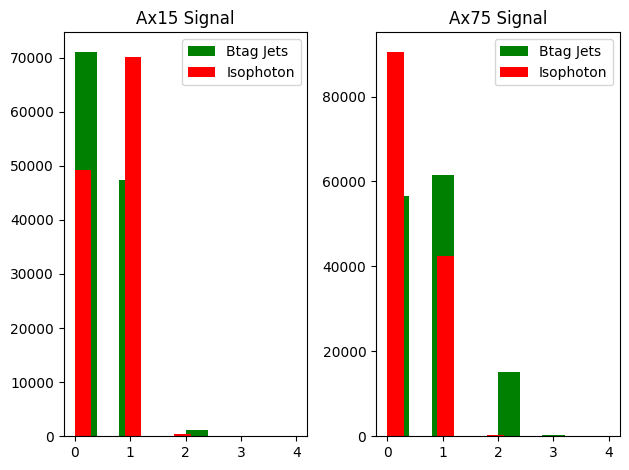

In [69]:
fig, axs = plt.subplots(1,2)
axs[0].hist(ax15_data_with_counts[ax15_data_with_counts['event_label'] == 1]['num_btag_jets'], color = 'green', label = "Btag Jets")
axs[0].hist(ax15_data_with_counts[ax15_data_with_counts['event_label'] == 1]['num_isophoton'], color = 'red', label = "Isophoton")
axs[0].set_title("Ax15 Signal")
axs[0].legend()

axs[1].hist(ax75_data_with_counts[ax75_data_with_counts['event_label'] == 1]['num_btag_jets'], color = 'green', label = "Btag Jets")
axs[1].hist(ax75_data_with_counts[ax75_data_with_counts['event_label'] == 1]['num_isophoton'], color = 'red', label = "Isophoton")
axs[1].set_title("Ax75 Signal")
axs[1].legend()

plt.tight_layout()
plt.show()

# Filtering 2j1p events

In [71]:
ax15_2j1p_mask = (ax15_data_with_counts.num_btag_jets == 2) & (ax15_data_with_counts.num_isophoton == 1)
ax15_2j1p_data = ax15_data_with_counts[ax15_2j1p_mask]

ax75_2j1p_mask = (ax75_data_with_counts.num_btag_jets == 2) & (ax75_data_with_counts.num_isophoton == 1)
ax75_2j1p_data = ax75_data_with_counts[ax75_2j1p_mask]

In [75]:
ax15_2j1p_data[ax15_2j1p_data['event_label'] == 1].shape

(582, 131)

In [76]:
ax75_2j1p_data[ax75_2j1p_data['event_label'] == 1].shape

(4790, 131)

# Saving the filtered events as txt file

In [77]:
ax75_2j1p_data.to_csv('./ax75_signalBackground_2j1p_data.txt', sep = '\t')
ax15_2j1p_data.to_csv('./ax15_signalBackground_2j1p_data.txt', sep = '\t')